In [1]:
from __future__ import division

# Import from the standard Python libraries
import math
import re
import json as simplejson
import numpy as np
import ntpath
import os
import csv
import pandas as pd
import time
import scipy.io
import seaborn as sn
from scipy.io import loadmat
import matplotlib
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
#This function is neaded to load the data from a folder
def Open_Data_File(num):
    
    #Read csv data 
    
    str_file = '487Pos_astrobot_pp_minmax' + str(num) + '_scaled_05.csv'
    Data = pd.read_csv(str_file)
    return(Data)

In [3]:
def Average_euclidean_distance(X_train):

    #This function compute an average of the euclidean distance between a sample of vectors
    # in order to have a first indication of what should be the order of magnitude of the kernel size
    
    #This function is useful only if the user want to perform a manual tuning of the kernel size
    
    size = X_train.shape[0]
    dist_vec=[]
    for i in range(0,round(size/600)):
    
        x1=X_train.to_numpy()[i]
        #print(x1)
    
        for j in range(0,round(size/600)):
        
            x2=X_train.to_numpy()[j]
            #print(x2)
        
            if np.array_equal(x1,x2):
                continue
            else:
                d = np.linalg.norm(x1-x2)
                dist_vec=np.append(dist_vec, d)
            
    

    
    return np.mean(dist_vec)

In [4]:
# This function perform the split into test dataset and train dataset in a sequential fashion, 
# according to the iteration K of the cross validation process

def K_train_test_split(X, y, test_size, K):
    
    size = X.shape[0]
    n_data_test=math.trunc(size*test_size)
    
    X_test = X.loc[(K-1)*n_data_test: K*n_data_test]
    y_test = y.loc[(K-1)*n_data_test: K*n_data_test]
    X_train = X.drop(X.index[(K-1)*n_data_test: K*n_data_test])
    y_train = y.drop(y.index[(K-1)*n_data_test: K*n_data_test])
                             
    return X_train, X_test, y_train, y_test                         

In [5]:
#This function computes the average values for the neighborhood analysis

def plot_neighborhoods_bar(tp6, tn6, ba6, tp5, tn5, ba5, tp4, tn4, ba4, tp3, tn3, ba3, tp2, tn2, ba2):
    
    plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
    
    labels = ['Astrobot with \n6 neighbours', 'Astrobot with \n5 neighbours', 'Astrobot with \n4 neighbours', 'Astrobot with \n3 neighbours', 'Astrobot with \n2 neighbours']
    tp_means = [100*np.mean(tp6), 100*np.mean(tp5), 100*np.mean(tp4), 100*np.mean(tp3), 100*np.mean(tp2)]
    tn_means = [100*np.mean(tn6), 100*np.mean(tn5), 100*np.mean(tn4), 100*np.mean(tn3), 100*np.mean(tn2)]
    ba_means = [100*np.mean(ba6), 100*np.mean(ba5), 100*np.mean(ba4), 100*np.mean(ba3), 100*np.mean(ba2)]
    
    x = np.arange(len(labels))  # the label locations
    width = 0.6  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/3 , tp_means, width/3, label='TPR')
    rects2 = ax.bar(x , tn_means, width/3, label='TNR')
    rects3 = ax.bar(x + width/3, ba_means, width/3, label='Bal. Acc.')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Accuracy [%]')
    ax.set_title('Neighborhood analysis')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    plt.ylim((0,100))
    plt.yticks(np.arange(0,100, 10.0))
    
    plt.rcParams['figure.figsize']=(30,25)
    plt.grid(1)
    #fig.tight_layout()
   # matplotlib.rcParams.update({'font.size': 32})

    plt.show()
    
    

In [6]:
path = r'C:\Users\Mauro\Master Thesis\SVM_487_Pos_parity_scaled05'
os.chdir(path)

list = os.listdir(path) # dir is your directory path
number_files = len(list)

In [ ]:
# CENTRAL ALGORITHM SVM

# Number of iterations of the cross-validation process
K=10

#Initialise the vectors for the analysis of the results
tp_vec=np.empty((0,number_files))
tn_vec=np.empty((0,number_files))
fp_vec=np.empty((0,number_files))
fn_vec=np.empty((0,number_files))

tp_rate_vec=np.empty((0,number_files))
tn_rate_vec=np.empty((0,number_files))
balacc_vec=np.empty((0,number_files))

tp_rate_6_neigh_avg = []
tn_rate_6_neigh_avg = []
balacc_6_neigh_avg = []

tp_rate_5_neigh_avg = []
tn_rate_5_neigh_avg = []
balacc_5_neigh_avg = []

tp_rate_4_neigh_avg = []
tn_rate_4_neigh_avg = []
balacc_4_neigh_avg = []

tp_rate_3_neigh_avg = []
tn_rate_3_neigh_avg = []
balacc_3_neigh_avg = []

tp_rate_2_neigh_avg = []
tn_rate_2_neigh_avg = []
balacc_2_neigh_avg = []


#OUTER LOOP - Cross validation proces
for k in range(1,K+1):
    
    print('Iteration number: ', k)
    
    #initialise the vector of results at each iteration
    prediction_results=np.empty((0,8))
    
    #INNER LOOP - Building a SVM model for each astrobot
    for i in range (1,number_files+1):

        #Comment this line of code if the focal plane is very crowded
        print('Astrobot number: ', i)

        #Open the data
        Data = Open_Data_File(i)

        #dividing attributes from labels
        X=Data.drop('label',axis=1)
        y=Data['label']

        n_of_attributes = X.shape[1]

        #number of neighbours of the astrobots (not considering parity)
        #n_neigh = (n_of_attributes - 2)/2
        
        #number of neighbours of the astrobots (considering parity)
        n_neigh = (n_of_attributes - 3)/3
        
        #comment the following line of code if not interested in knowing
        #the number of neighbors of the astrobot
        print('number of neighbours: ', n_neigh)

        #Split data
        #The third argument of the function indicates the ratio D_test/(D_test + D_train)
        X_train, X_test, y_train, y_test = K_train_test_split(X, y, 0.1, k)

        
        #SVC predictor - Setting the hyperparameters for each type of astrobot in the focal plane

        if n_neigh == 6:
            
            #Hyperparameters for a neighborhood with 6 neighbours
            GAMMA = 1.6
            w1 = 0.289474
            
        elif n_neigh == 5:
            
            #Hyperparameters for a neighborhood with 5 neighbours
            GAMMA = 1.6
            w1 = 0.252632
            
        elif n_neigh == 4:
            
            #Hyperparameters for a neighborhood with 4 neighbours
            GAMMA = 1.7
            w1 = 0.197368
            
        elif n_neigh == 3:
            
            #Hyperparameters for a neighborhood with 3 neighbours
            GAMMA = 1.8
            w1 = 0.142105
            
        elif n_neigh == 2:
            
            #Hyperparameters for a neighborhood with 2 neighbours
            GAMMA = 1.8
            w1 = 0.105263


        #Building and training the predictor
        #The missclassification penalty is fixed and has been found manually
        svclassifier = SVC(kernel='rbf', C=1, class_weight={1: w1}, gamma=GAMMA, cache_size=400)
        
        #Training the predictor using the training dataset
        svclassifier.fit(X_train, y_train)

        #Evaluate predictor using the test dataset
        y_pred = svclassifier.predict(X_test)

        #Calculating the number of TP,TN,FP and FN for the classifier, using the prediction y_pred and the
        # true labels of the test samples y_test
        
        tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
        
        #Calculate the TPR, TNR and Balanced accuracy using the values of TP, TN, FP and FN obtained
        TPR=tp/(tp+fn)
        TNR=tn/(tn+fp)
        BalAcc=(TPR + TNR)/2

        info_vec = np.array([n_neigh, tp, tn, fp, fn, TPR, TNR, BalAcc])
        #print(info_vec)
        #print('\nTPR: ',TPR)
        #print('\nTNR: ',TNR)
        #print('\nBalanced Accuracy: ', BalAcc)
        prediction_results=np.vstack((prediction_results, info_vec))





        #wait = input("PRESS ENTER TO CONTINUE.")
        
    indeces_6_neigh = np.equal(prediction_results[:,0],6)
    tp_rate_6_neigh_avg = np.append(tp_rate_6_neigh_avg, np.mean(prediction_results[indeces_6_neigh,5]))
    tn_rate_6_neigh_avg = np.append(tn_rate_6_neigh_avg, np.mean(prediction_results[indeces_6_neigh,6]))
    balacc_6_neigh_avg = np.append(balacc_6_neigh_avg, np.mean(prediction_results[indeces_6_neigh,7]))
    
    indeces_5_neigh = np.equal(prediction_results[:,0],5)
    tp_rate_5_neigh_avg = np.append(tp_rate_5_neigh_avg, np.mean(prediction_results[indeces_5_neigh,5]))
    tn_rate_5_neigh_avg = np.append(tn_rate_5_neigh_avg, np.mean(prediction_results[indeces_5_neigh,6]))
    balacc_5_neigh_avg = np.append(balacc_5_neigh_avg, np.mean(prediction_results[indeces_5_neigh,7]))
    
    indeces_4_neigh = np.equal(prediction_results[:,0],4)
    tp_rate_4_neigh_avg = np.append(tp_rate_4_neigh_avg, np.mean(prediction_results[indeces_4_neigh,5]))
    tn_rate_4_neigh_avg = np.append(tn_rate_4_neigh_avg, np.mean(prediction_results[indeces_4_neigh,6]))
    balacc_4_neigh_avg = np.append(balacc_4_neigh_avg, np.mean(prediction_results[indeces_4_neigh,7]))
    
    indeces_3_neigh = np.equal(prediction_results[:,0],3)
    tp_rate_3_neigh_avg = np.append(tp_rate_3_neigh_avg, np.mean(prediction_results[indeces_3_neigh,5]))
    tn_rate_3_neigh_avg = np.append(tn_rate_3_neigh_avg, np.mean(prediction_results[indeces_3_neigh,6]))
    balacc_3_neigh_avg = np.append(balacc_3_neigh_avg, np.mean(prediction_results[indeces_3_neigh,7]))
    
    indeces_2_neigh = np.equal(prediction_results[:,0],2)
    tp_rate_2_neigh_avg = np.append(tp_rate_2_neigh_avg, np.mean(prediction_results[indeces_2_neigh,5]))
    tn_rate_2_neigh_avg = np.append(tn_rate_2_neigh_avg, np.mean(prediction_results[indeces_2_neigh,6]))
    balacc_2_neigh_avg = np.append(balacc_2_neigh_avg, np.mean(prediction_results[indeces_2_neigh,7]))
    
    tp_vec = np.vstack((tp_vec,prediction_results[:,1]))
    tn_vec = np.vstack((tn_vec,prediction_results[:,2]))
    fp_vec = np.vstack((fp_vec,prediction_results[:,3]))
    fn_vec = np.vstack((fn_vec,prediction_results[:,4]))
    tp_rate_vec = np.vstack((tp_rate_vec, prediction_results[:,5]))
    tn_rate_vec = np.vstack((tn_rate_vec, prediction_results[:,6]))
    balacc_vec = np.vstack((balacc_vec, prediction_results[:,7]))
    


Iteration number:  1
Astrobot number:  1
number of neighbours:  4.0
Astrobot number:  2
number of neighbours:  5.0
Astrobot number:  3
number of neighbours:  5.0
Astrobot number:  4
number of neighbours:  5.0
Astrobot number:  5
number of neighbours:  3.0
Astrobot number:  6
number of neighbours:  5.0
Astrobot number:  7
number of neighbours:  6.0
Astrobot number:  8
number of neighbours:  6.0
Astrobot number:  9
number of neighbours:  6.0
Astrobot number:  10
number of neighbours:  6.0
Astrobot number:  11
number of neighbours:  6.0
Astrobot number:  12
number of neighbours:  6.0
Astrobot number:  13
number of neighbours:  5.0
Astrobot number:  14
number of neighbours:  5.0
Astrobot number:  15
number of neighbours:  4.0
Astrobot number:  16
number of neighbours:  5.0
Astrobot number:  17
number of neighbours:  6.0
Astrobot number:  18
number of neighbours:  6.0
Astrobot number:  19
number of neighbours:  6.0
Astrobot number:  20
number of neighbours:  6.0
Astrobot number:  21
number 

Astrobot number:  170
number of neighbours:  5.0
Astrobot number:  171
number of neighbours:  5.0
Astrobot number:  172
number of neighbours:  6.0
Astrobot number:  173
number of neighbours:  6.0
Astrobot number:  174
number of neighbours:  6.0
Astrobot number:  175
number of neighbours:  6.0
Astrobot number:  176
number of neighbours:  6.0
Astrobot number:  177
number of neighbours:  6.0
Astrobot number:  178
number of neighbours:  6.0
Astrobot number:  179
number of neighbours:  6.0
Astrobot number:  180
number of neighbours:  6.0
Astrobot number:  181
number of neighbours:  6.0
Astrobot number:  182
number of neighbours:  6.0
Astrobot number:  183
number of neighbours:  6.0
Astrobot number:  184
number of neighbours:  6.0
Astrobot number:  185
number of neighbours:  6.0
Astrobot number:  186
number of neighbours:  6.0
Astrobot number:  187
number of neighbours:  6.0
Astrobot number:  188
number of neighbours:  6.0
Astrobot number:  189
number of neighbours:  6.0
Astrobot number:  19

Astrobot number:  338
number of neighbours:  6.0
Astrobot number:  339
number of neighbours:  6.0
Astrobot number:  340
number of neighbours:  5.0
Astrobot number:  341
number of neighbours:  5.0
Astrobot number:  342
number of neighbours:  5.0
Astrobot number:  343
number of neighbours:  6.0
Astrobot number:  344
number of neighbours:  6.0
Astrobot number:  345
number of neighbours:  6.0
Astrobot number:  346
number of neighbours:  6.0
Astrobot number:  347
number of neighbours:  6.0
Astrobot number:  348
number of neighbours:  6.0
Astrobot number:  349
number of neighbours:  6.0
Astrobot number:  350
number of neighbours:  5.0
Astrobot number:  351
number of neighbours:  5.0
Astrobot number:  352
number of neighbours:  6.0
Astrobot number:  353
number of neighbours:  6.0
Astrobot number:  354
number of neighbours:  6.0
Astrobot number:  355
number of neighbours:  6.0
Astrobot number:  356
number of neighbours:  6.0
Astrobot number:  357
number of neighbours:  6.0
Astrobot number:  35

Astrobot number:  19
number of neighbours:  6.0
Astrobot number:  20
number of neighbours:  6.0
Astrobot number:  21
number of neighbours:  6.0
Astrobot number:  22
number of neighbours:  5.0
Astrobot number:  23
number of neighbours:  6.0
Astrobot number:  24
number of neighbours:  6.0
Astrobot number:  25
number of neighbours:  5.0
Astrobot number:  26
number of neighbours:  6.0
Astrobot number:  27
number of neighbours:  5.0
Astrobot number:  28
number of neighbours:  5.0
Astrobot number:  29
number of neighbours:  5.0
Astrobot number:  30
number of neighbours:  5.0
Astrobot number:  31
number of neighbours:  5.0
Astrobot number:  32
number of neighbours:  6.0
Astrobot number:  33
number of neighbours:  6.0
Astrobot number:  34
number of neighbours:  6.0
Astrobot number:  35
number of neighbours:  6.0
Astrobot number:  36
number of neighbours:  6.0
Astrobot number:  37
number of neighbours:  6.0
Astrobot number:  38
number of neighbours:  6.0
Astrobot number:  39
number of neighbour

Astrobot number:  188
number of neighbours:  6.0
Astrobot number:  189
number of neighbours:  6.0
Astrobot number:  190
number of neighbours:  6.0
Astrobot number:  191
number of neighbours:  6.0
Astrobot number:  192
number of neighbours:  5.0
Astrobot number:  193
number of neighbours:  5.0
Astrobot number:  194
number of neighbours:  5.0
Astrobot number:  195
number of neighbours:  6.0
Astrobot number:  196
number of neighbours:  6.0
Astrobot number:  197
number of neighbours:  6.0
Astrobot number:  198
number of neighbours:  6.0
Astrobot number:  199
number of neighbours:  6.0
Astrobot number:  200
number of neighbours:  5.0
Astrobot number:  201
number of neighbours:  5.0
Astrobot number:  202
number of neighbours:  6.0
Astrobot number:  203
number of neighbours:  6.0
Astrobot number:  204
number of neighbours:  6.0
Astrobot number:  205
number of neighbours:  6.0
Astrobot number:  206
number of neighbours:  6.0
Astrobot number:  207
number of neighbours:  5.0
Astrobot number:  20

Astrobot number:  356
number of neighbours:  6.0
Astrobot number:  357
number of neighbours:  6.0
Astrobot number:  358
number of neighbours:  6.0
Astrobot number:  359
number of neighbours:  6.0
Astrobot number:  360
number of neighbours:  6.0
Astrobot number:  361
number of neighbours:  6.0
Astrobot number:  362
number of neighbours:  6.0
Astrobot number:  363
number of neighbours:  6.0
Astrobot number:  364
number of neighbours:  6.0
Astrobot number:  365
number of neighbours:  6.0
Astrobot number:  366
number of neighbours:  6.0
Astrobot number:  367
number of neighbours:  6.0
Astrobot number:  368
number of neighbours:  6.0
Astrobot number:  369
number of neighbours:  6.0
Astrobot number:  370
number of neighbours:  6.0
Astrobot number:  371
number of neighbours:  6.0
Astrobot number:  372
number of neighbours:  6.0
Astrobot number:  373
number of neighbours:  6.0
Astrobot number:  374
number of neighbours:  6.0
Astrobot number:  375
number of neighbours:  6.0
Astrobot number:  37

Astrobot number:  37
number of neighbours:  6.0
Astrobot number:  38
number of neighbours:  6.0
Astrobot number:  39
number of neighbours:  6.0
Astrobot number:  40
number of neighbours:  5.0
Astrobot number:  41
number of neighbours:  5.0
Astrobot number:  42
number of neighbours:  6.0
Astrobot number:  43
number of neighbours:  5.0
Astrobot number:  44
number of neighbours:  5.0
Astrobot number:  45
number of neighbours:  6.0
Astrobot number:  46
number of neighbours:  5.0
Astrobot number:  47
number of neighbours:  5.0
Astrobot number:  48
number of neighbours:  5.0
Astrobot number:  49
number of neighbours:  6.0
Astrobot number:  50
number of neighbours:  6.0
Astrobot number:  51
number of neighbours:  6.0
Astrobot number:  52
number of neighbours:  6.0
Astrobot number:  53
number of neighbours:  6.0
Astrobot number:  54
number of neighbours:  6.0
Astrobot number:  55
number of neighbours:  6.0
Astrobot number:  56
number of neighbours:  6.0
Astrobot number:  57
number of neighbour

Astrobot number:  206
number of neighbours:  6.0
Astrobot number:  207
number of neighbours:  5.0
Astrobot number:  208
number of neighbours:  5.0
Astrobot number:  209
number of neighbours:  6.0
Astrobot number:  210
number of neighbours:  6.0
Astrobot number:  211
number of neighbours:  6.0
Astrobot number:  212
number of neighbours:  6.0
Astrobot number:  213
number of neighbours:  6.0
Astrobot number:  214
number of neighbours:  6.0
Astrobot number:  215
number of neighbours:  6.0
Astrobot number:  216
number of neighbours:  6.0
Astrobot number:  217
number of neighbours:  6.0
Astrobot number:  218
number of neighbours:  5.0
Astrobot number:  219
number of neighbours:  5.0
Astrobot number:  220
number of neighbours:  6.0
Astrobot number:  221
number of neighbours:  6.0
Astrobot number:  222
number of neighbours:  6.0
Astrobot number:  223
number of neighbours:  6.0
Astrobot number:  224
number of neighbours:  6.0
Astrobot number:  225
number of neighbours:  6.0
Astrobot number:  22

Astrobot number:  374
number of neighbours:  6.0
Astrobot number:  375
number of neighbours:  6.0
Astrobot number:  376
number of neighbours:  6.0
Astrobot number:  377
number of neighbours:  6.0
Astrobot number:  378
number of neighbours:  6.0
Astrobot number:  379
number of neighbours:  6.0
Astrobot number:  380
number of neighbours:  6.0
Astrobot number:  381
number of neighbours:  6.0
Astrobot number:  382
number of neighbours:  6.0
Astrobot number:  383
number of neighbours:  6.0
Astrobot number:  384
number of neighbours:  6.0
Astrobot number:  385
number of neighbours:  6.0
Astrobot number:  386
number of neighbours:  6.0
Astrobot number:  387
number of neighbours:  6.0
Astrobot number:  388
number of neighbours:  6.0
Astrobot number:  389
number of neighbours:  6.0
Astrobot number:  390
number of neighbours:  6.0
Astrobot number:  391
number of neighbours:  6.0
Astrobot number:  392
number of neighbours:  6.0
Astrobot number:  393
number of neighbours:  6.0
Astrobot number:  39

Astrobot number:  56
number of neighbours:  6.0
Astrobot number:  57
number of neighbours:  6.0
Astrobot number:  58
number of neighbours:  6.0
Astrobot number:  59
number of neighbours:  6.0
Astrobot number:  60
number of neighbours:  6.0
Astrobot number:  61
number of neighbours:  6.0
Astrobot number:  62
number of neighbours:  6.0
Astrobot number:  63
number of neighbours:  6.0
Astrobot number:  64
number of neighbours:  5.0
Astrobot number:  65
number of neighbours:  5.0
Astrobot number:  66
number of neighbours:  5.0
Astrobot number:  67
number of neighbours:  6.0
Astrobot number:  68
number of neighbours:  6.0
Astrobot number:  69
number of neighbours:  5.0
Astrobot number:  70
number of neighbours:  5.0
Astrobot number:  71
number of neighbours:  5.0
Astrobot number:  72
number of neighbours:  6.0
Astrobot number:  73
number of neighbours:  6.0
Astrobot number:  74
number of neighbours:  6.0
Astrobot number:  75
number of neighbours:  6.0
Astrobot number:  76
number of neighbour

Astrobot number:  225
number of neighbours:  6.0
Astrobot number:  226
number of neighbours:  5.0
Astrobot number:  227
number of neighbours:  6.0
Astrobot number:  228
number of neighbours:  6.0
Astrobot number:  229
number of neighbours:  6.0
Astrobot number:  230
number of neighbours:  6.0
Astrobot number:  231
number of neighbours:  6.0
Astrobot number:  232
number of neighbours:  6.0
Astrobot number:  233
number of neighbours:  6.0
Astrobot number:  234
number of neighbours:  5.0
Astrobot number:  235
number of neighbours:  5.0
Astrobot number:  236
number of neighbours:  6.0
Astrobot number:  237
number of neighbours:  6.0
Astrobot number:  238
number of neighbours:  6.0
Astrobot number:  239
number of neighbours:  6.0
Astrobot number:  240
number of neighbours:  6.0
Astrobot number:  241
number of neighbours:  6.0
Astrobot number:  242
number of neighbours:  6.0
Astrobot number:  243
number of neighbours:  6.0
Astrobot number:  244
number of neighbours:  6.0
Astrobot number:  24

Astrobot number:  393
number of neighbours:  6.0
Astrobot number:  394
number of neighbours:  6.0
Astrobot number:  395
number of neighbours:  6.0
Astrobot number:  396
number of neighbours:  6.0
Astrobot number:  397
number of neighbours:  5.0
Astrobot number:  398
number of neighbours:  5.0
Astrobot number:  399
number of neighbours:  6.0
Astrobot number:  400
number of neighbours:  6.0
Astrobot number:  401
number of neighbours:  6.0
Astrobot number:  402
number of neighbours:  6.0
Astrobot number:  403
number of neighbours:  6.0
Astrobot number:  404
number of neighbours:  6.0
Astrobot number:  405
number of neighbours:  6.0
Astrobot number:  406
number of neighbours:  6.0
Astrobot number:  407
number of neighbours:  6.0
Astrobot number:  408
number of neighbours:  6.0
Astrobot number:  409
number of neighbours:  6.0
Astrobot number:  410
number of neighbours:  6.0
Astrobot number:  411
number of neighbours:  6.0
Astrobot number:  412
number of neighbours:  6.0
Astrobot number:  41

Astrobot number:  75
number of neighbours:  6.0
Astrobot number:  76
number of neighbours:  6.0
Astrobot number:  77
number of neighbours:  6.0
Astrobot number:  78
number of neighbours:  6.0
Astrobot number:  79
number of neighbours:  6.0
Astrobot number:  80
number of neighbours:  6.0
Astrobot number:  81
number of neighbours:  6.0
Astrobot number:  82
number of neighbours:  6.0
Astrobot number:  83
number of neighbours:  6.0
Astrobot number:  84
number of neighbours:  6.0
Astrobot number:  85
number of neighbours:  6.0
Astrobot number:  86
number of neighbours:  6.0
Astrobot number:  87
number of neighbours:  6.0
Astrobot number:  88
number of neighbours:  6.0
Astrobot number:  89
number of neighbours:  6.0
Astrobot number:  90
number of neighbours:  6.0
Astrobot number:  91
number of neighbours:  6.0
Astrobot number:  92
number of neighbours:  6.0
Astrobot number:  93
number of neighbours:  6.0
Astrobot number:  94
number of neighbours:  6.0
Astrobot number:  95
number of neighbour

Astrobot number:  243
number of neighbours:  6.0
Astrobot number:  244
number of neighbours:  6.0
Astrobot number:  245
number of neighbours:  6.0
Astrobot number:  246
number of neighbours:  6.0
Astrobot number:  247
number of neighbours:  6.0
Astrobot number:  248
number of neighbours:  6.0
Astrobot number:  249
number of neighbours:  6.0
Astrobot number:  250
number of neighbours:  6.0
Astrobot number:  251
number of neighbours:  6.0
Astrobot number:  252
number of neighbours:  5.0
Astrobot number:  253
number of neighbours:  5.0
Astrobot number:  254
number of neighbours:  5.0
Astrobot number:  255
number of neighbours:  6.0
Astrobot number:  256
number of neighbours:  6.0
Astrobot number:  257
number of neighbours:  6.0
Astrobot number:  258
number of neighbours:  6.0
Astrobot number:  259
number of neighbours:  6.0
Astrobot number:  260
number of neighbours:  5.0
Astrobot number:  261
number of neighbours:  5.0
Astrobot number:  262
number of neighbours:  6.0
Astrobot number:  26

Astrobot number:  411
number of neighbours:  6.0
Astrobot number:  412
number of neighbours:  6.0
Astrobot number:  413
number of neighbours:  6.0
Astrobot number:  414
number of neighbours:  5.0
Astrobot number:  415
number of neighbours:  4.0
Astrobot number:  416
number of neighbours:  4.0
Astrobot number:  417
number of neighbours:  4.0
Astrobot number:  418
number of neighbours:  4.0
Astrobot number:  419
number of neighbours:  4.0
Astrobot number:  420
number of neighbours:  4.0
Astrobot number:  421
number of neighbours:  3.0
Astrobot number:  422
number of neighbours:  4.0
Astrobot number:  423
number of neighbours:  4.0
Astrobot number:  424
number of neighbours:  4.0
Astrobot number:  425
number of neighbours:  4.0
Astrobot number:  426
number of neighbours:  4.0
Astrobot number:  427
number of neighbours:  4.0
Astrobot number:  428
number of neighbours:  4.0
Astrobot number:  429
number of neighbours:  4.0
Astrobot number:  430
number of neighbours:  4.0
Astrobot number:  43

Astrobot number:  93
number of neighbours:  6.0
Astrobot number:  94
number of neighbours:  6.0
Astrobot number:  95
number of neighbours:  6.0
Astrobot number:  96
number of neighbours:  6.0
Astrobot number:  97
number of neighbours:  6.0
Astrobot number:  98
number of neighbours:  6.0
Astrobot number:  99
number of neighbours:  6.0
Astrobot number:  100
number of neighbours:  6.0
Astrobot number:  101
number of neighbours:  6.0
Astrobot number:  102
number of neighbours:  6.0
Astrobot number:  103
number of neighbours:  6.0
Astrobot number:  104
number of neighbours:  6.0
Astrobot number:  105
number of neighbours:  6.0
Astrobot number:  106
number of neighbours:  6.0
Astrobot number:  107
number of neighbours:  6.0
Astrobot number:  108
number of neighbours:  6.0
Astrobot number:  109
number of neighbours:  5.0
Astrobot number:  110
number of neighbours:  6.0
Astrobot number:  111
number of neighbours:  6.0
Astrobot number:  112
number of neighbours:  6.0
Astrobot number:  113
numbe

Astrobot number:  261
number of neighbours:  5.0
Astrobot number:  262
number of neighbours:  6.0
Astrobot number:  263
number of neighbours:  6.0
Astrobot number:  264
number of neighbours:  6.0
Astrobot number:  265
number of neighbours:  6.0
Astrobot number:  266
number of neighbours:  6.0
Astrobot number:  267
number of neighbours:  6.0
Astrobot number:  268
number of neighbours:  6.0
Astrobot number:  269
number of neighbours:  6.0
Astrobot number:  270
number of neighbours:  6.0
Astrobot number:  271
number of neighbours:  6.0
Astrobot number:  272
number of neighbours:  6.0
Astrobot number:  273
number of neighbours:  6.0
Astrobot number:  274
number of neighbours:  6.0
Astrobot number:  275
number of neighbours:  6.0
Astrobot number:  276
number of neighbours:  6.0
Astrobot number:  277
number of neighbours:  6.0
Astrobot number:  278
number of neighbours:  6.0
Astrobot number:  279
number of neighbours:  6.0
Astrobot number:  280
number of neighbours:  5.0
Astrobot number:  28

Astrobot number:  429
number of neighbours:  4.0
Astrobot number:  430
number of neighbours:  4.0
Astrobot number:  431
number of neighbours:  4.0
Astrobot number:  432
number of neighbours:  4.0
Astrobot number:  433
number of neighbours:  3.0
Astrobot number:  434
number of neighbours:  4.0
Astrobot number:  435
number of neighbours:  4.0
Astrobot number:  436
number of neighbours:  4.0
Astrobot number:  437
number of neighbours:  4.0
Astrobot number:  438
number of neighbours:  4.0
Astrobot number:  439
number of neighbours:  4.0
Astrobot number:  440
number of neighbours:  4.0
Astrobot number:  441
number of neighbours:  4.0
Astrobot number:  442
number of neighbours:  4.0
Astrobot number:  443
number of neighbours:  4.0
Astrobot number:  444
number of neighbours:  4.0
Astrobot number:  445
number of neighbours:  3.0
Astrobot number:  446
number of neighbours:  4.0
Astrobot number:  447
number of neighbours:  4.0
Astrobot number:  448
number of neighbours:  4.0
Astrobot number:  44

Astrobot number:  111
number of neighbours:  6.0
Astrobot number:  112
number of neighbours:  6.0
Astrobot number:  113
number of neighbours:  6.0
Astrobot number:  114
number of neighbours:  6.0
Astrobot number:  115
number of neighbours:  6.0
Astrobot number:  116
number of neighbours:  6.0
Astrobot number:  117
number of neighbours:  6.0
Astrobot number:  118
number of neighbours:  6.0
Astrobot number:  119
number of neighbours:  6.0
Astrobot number:  120
number of neighbours:  6.0
Astrobot number:  121
number of neighbours:  6.0
Astrobot number:  122
number of neighbours:  6.0
Astrobot number:  123
number of neighbours:  6.0
Astrobot number:  124
number of neighbours:  6.0
Astrobot number:  125
number of neighbours:  6.0
Astrobot number:  126
number of neighbours:  6.0
Astrobot number:  127
number of neighbours:  6.0
Astrobot number:  128
number of neighbours:  5.0
Astrobot number:  129
number of neighbours:  5.0
Astrobot number:  130
number of neighbours:  6.0
Astrobot number:  13

Astrobot number:  279
number of neighbours:  6.0
Astrobot number:  280
number of neighbours:  5.0
Astrobot number:  281
number of neighbours:  5.0
Astrobot number:  282
number of neighbours:  6.0
Astrobot number:  283
number of neighbours:  6.0
Astrobot number:  284
number of neighbours:  6.0
Astrobot number:  285
number of neighbours:  6.0
Astrobot number:  286
number of neighbours:  6.0
Astrobot number:  287
number of neighbours:  6.0
Astrobot number:  288
number of neighbours:  5.0
Astrobot number:  289
number of neighbours:  5.0
Astrobot number:  290
number of neighbours:  6.0
Astrobot number:  291
number of neighbours:  6.0
Astrobot number:  292
number of neighbours:  6.0
Astrobot number:  293
number of neighbours:  6.0
Astrobot number:  294
number of neighbours:  6.0
Astrobot number:  295
number of neighbours:  6.0
Astrobot number:  296
number of neighbours:  6.0
Astrobot number:  297
number of neighbours:  6.0
Astrobot number:  298
number of neighbours:  6.0
Astrobot number:  29

Astrobot number:  447
number of neighbours:  4.0
Astrobot number:  448
number of neighbours:  4.0
Astrobot number:  449
number of neighbours:  4.0
Astrobot number:  450
number of neighbours:  4.0
Astrobot number:  451
number of neighbours:  4.0
Astrobot number:  452
number of neighbours:  4.0
Astrobot number:  453
number of neighbours:  4.0
Astrobot number:  454
number of neighbours:  4.0
Astrobot number:  455
number of neighbours:  4.0
Astrobot number:  456
number of neighbours:  4.0
Astrobot number:  457
number of neighbours:  4.0
Astrobot number:  458
number of neighbours:  3.0
Astrobot number:  459
number of neighbours:  4.0
Astrobot number:  460
number of neighbours:  4.0
Astrobot number:  461
number of neighbours:  4.0
Astrobot number:  462
number of neighbours:  4.0
Astrobot number:  463
number of neighbours:  4.0
Astrobot number:  464
number of neighbours:  4.0
Astrobot number:  465
number of neighbours:  4.0
Astrobot number:  466
number of neighbours:  4.0
Astrobot number:  46

Astrobot number:  129
number of neighbours:  5.0
Astrobot number:  130
number of neighbours:  6.0
Astrobot number:  131
number of neighbours:  6.0
Astrobot number:  132
number of neighbours:  6.0
Astrobot number:  133
number of neighbours:  6.0
Astrobot number:  134
number of neighbours:  6.0
Astrobot number:  135
number of neighbours:  6.0
Astrobot number:  136
number of neighbours:  6.0
Astrobot number:  137
number of neighbours:  6.0
Astrobot number:  138
number of neighbours:  6.0
Astrobot number:  139
number of neighbours:  6.0
Astrobot number:  140
number of neighbours:  6.0
Astrobot number:  141
number of neighbours:  6.0
Astrobot number:  142
number of neighbours:  6.0
Astrobot number:  143
number of neighbours:  6.0
Astrobot number:  144
number of neighbours:  6.0
Astrobot number:  145
number of neighbours:  6.0
Astrobot number:  146
number of neighbours:  6.0
Astrobot number:  147
number of neighbours:  6.0
Astrobot number:  148
number of neighbours:  5.0
Astrobot number:  14

Astrobot number:  297
number of neighbours:  6.0
Astrobot number:  298
number of neighbours:  6.0
Astrobot number:  299
number of neighbours:  6.0
Astrobot number:  300
number of neighbours:  6.0
Astrobot number:  301
number of neighbours:  6.0
Astrobot number:  302
number of neighbours:  6.0
Astrobot number:  303
number of neighbours:  6.0
Astrobot number:  304
number of neighbours:  6.0
Astrobot number:  305
number of neighbours:  6.0
Astrobot number:  306
number of neighbours:  6.0
Astrobot number:  307
number of neighbours:  6.0
Astrobot number:  308
number of neighbours:  6.0
Astrobot number:  309
number of neighbours:  6.0
Astrobot number:  310
number of neighbours:  6.0
Astrobot number:  311
number of neighbours:  6.0
Astrobot number:  312
number of neighbours:  6.0
Astrobot number:  313
number of neighbours:  6.0
Astrobot number:  314
number of neighbours:  6.0
Astrobot number:  315
number of neighbours:  6.0
Astrobot number:  316
number of neighbours:  6.0
Astrobot number:  31

Astrobot number:  465
number of neighbours:  4.0
Astrobot number:  466
number of neighbours:  4.0
Astrobot number:  467
number of neighbours:  4.0
Astrobot number:  468
number of neighbours:  4.0
Astrobot number:  469
number of neighbours:  4.0
Astrobot number:  470
number of neighbours:  2.0
Astrobot number:  471
number of neighbours:  3.0
Astrobot number:  472
number of neighbours:  4.0
Astrobot number:  473
number of neighbours:  4.0
Astrobot number:  474
number of neighbours:  4.0
Astrobot number:  475
number of neighbours:  4.0
Astrobot number:  476
number of neighbours:  4.0
Astrobot number:  477
number of neighbours:  4.0
Astrobot number:  478
number of neighbours:  4.0
Astrobot number:  479
number of neighbours:  4.0
Astrobot number:  480
number of neighbours:  4.0
Astrobot number:  481
number of neighbours:  4.0
Astrobot number:  482
number of neighbours:  3.0
Astrobot number:  483
number of neighbours:  4.0
Astrobot number:  484
number of neighbours:  4.0
Astrobot number:  48

Astrobot number:  147
number of neighbours:  6.0
Astrobot number:  148
number of neighbours:  5.0
Astrobot number:  149
number of neighbours:  5.0
Astrobot number:  150
number of neighbours:  6.0
Astrobot number:  151
number of neighbours:  6.0
Astrobot number:  152
number of neighbours:  6.0
Astrobot number:  153
number of neighbours:  6.0
Astrobot number:  154
number of neighbours:  6.0
Astrobot number:  155
number of neighbours:  5.0
Astrobot number:  156
number of neighbours:  6.0
Astrobot number:  157
number of neighbours:  6.0
Astrobot number:  158
number of neighbours:  6.0
Astrobot number:  159
number of neighbours:  6.0
Astrobot number:  160
number of neighbours:  6.0
Astrobot number:  161
number of neighbours:  6.0
Astrobot number:  162
number of neighbours:  6.0
Astrobot number:  163
number of neighbours:  6.0
Astrobot number:  164
number of neighbours:  6.0
Astrobot number:  165
number of neighbours:  6.0
Astrobot number:  166
number of neighbours:  6.0
Astrobot number:  16

Astrobot number:  315
number of neighbours:  6.0
Astrobot number:  316
number of neighbours:  6.0
Astrobot number:  317
number of neighbours:  5.0
Astrobot number:  318
number of neighbours:  5.0
Astrobot number:  319
number of neighbours:  6.0
Astrobot number:  320
number of neighbours:  6.0
Astrobot number:  321
number of neighbours:  6.0
Astrobot number:  322
number of neighbours:  6.0
Astrobot number:  323
number of neighbours:  6.0
Astrobot number:  324
number of neighbours:  6.0
Astrobot number:  325
number of neighbours:  6.0
Astrobot number:  326
number of neighbours:  6.0
Astrobot number:  327
number of neighbours:  6.0
Astrobot number:  328
number of neighbours:  6.0
Astrobot number:  329
number of neighbours:  6.0
Astrobot number:  330
number of neighbours:  6.0
Astrobot number:  331
number of neighbours:  6.0
Astrobot number:  332
number of neighbours:  6.0
Astrobot number:  333
number of neighbours:  6.0
Astrobot number:  334
number of neighbours:  6.0
Astrobot number:  33

TPR average:  [80.4435150013384, 81.9270938152464, 84.33441795876938, 84.1390510823033, 85.41570600582997]
TNR average:  [53.00229468055729, 58.49704794137388, 62.797709847351456, 75.19353279220036, 84.33753881372724]
Bal. Acc. average:  [66.72290484094783, 70.21207087831014, 73.56606390306041, 79.66629193725183, 84.8766224097786]


<Figure size 1120x640 with 0 Axes>

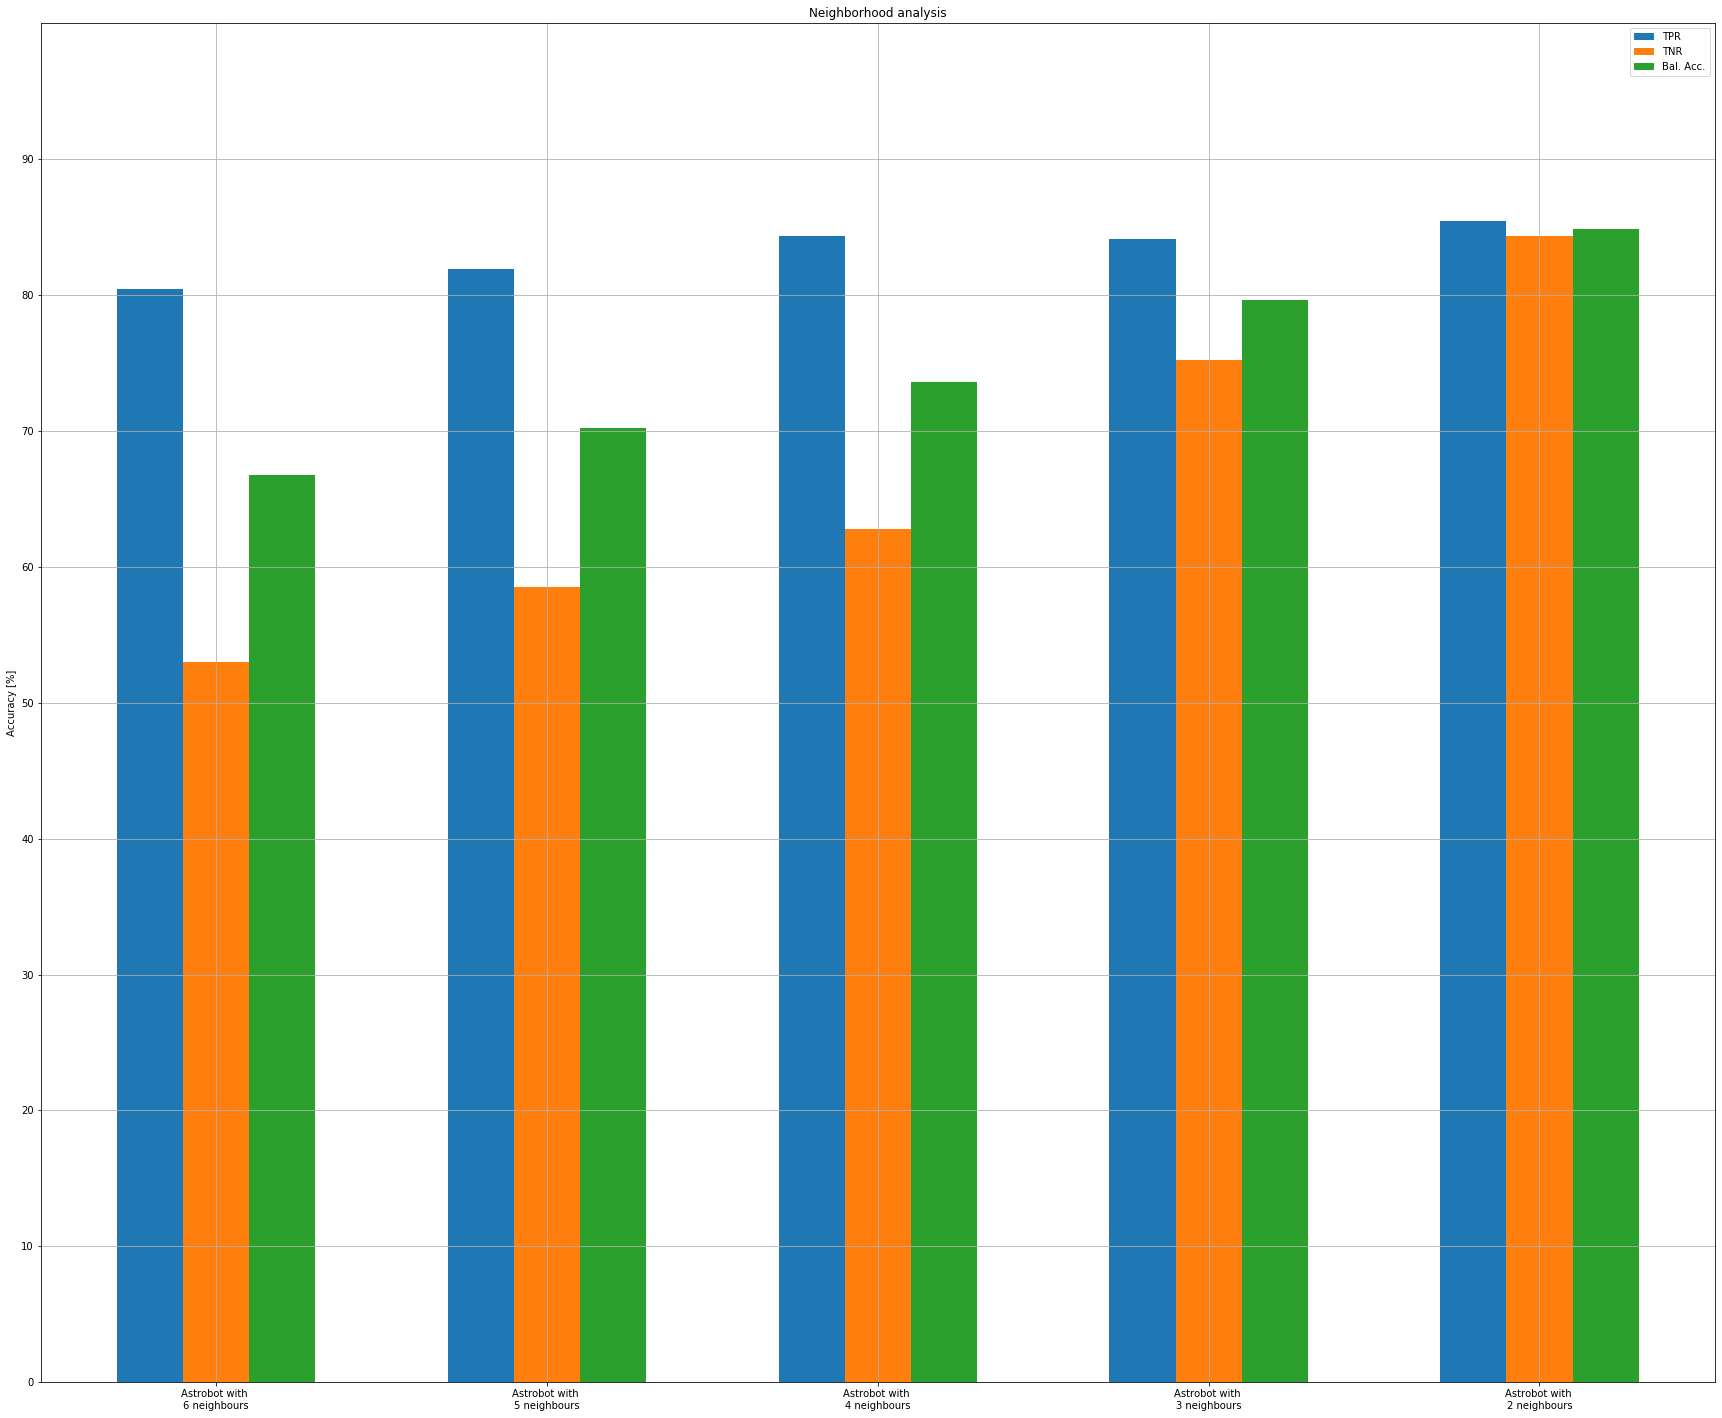

In [36]:
prediction_results.shape

mean_results = np.mean(prediction_results[:,1:8], axis=0)
#print(mean_results)

TP_tot=np.sum(prediction_results[:,1])
TN_tot=np.sum(prediction_results[:,2])
FP_tot=np.sum(prediction_results[:,3])
FN_tot=np.sum(prediction_results[:,4])

#print(TP_tot, TN_tot, FP_tot, FN_tot)

tp_means = [100*np.mean(tp_rate_6_neigh_avg), 100*np.mean(tp_rate_5_neigh_avg), 100*np.mean(tp_rate_4_neigh_avg), 100*np.mean(tp_rate_3_neigh_avg),100*np.mean(tp_rate_2_neigh_avg)]
tn_means = [100*np.mean(tn_rate_6_neigh_avg), 100*np.mean(tn_rate_5_neigh_avg), 100*np.mean(tn_rate_4_neigh_avg), 100*np.mean(tn_rate_3_neigh_avg), 100*np.mean(tn_rate_2_neigh_avg)]
ba_means = [100*np.mean(balacc_6_neigh_avg), 100*np.mean(balacc_5_neigh_avg), 100*np.mean(balacc_4_neigh_avg), 100*np.mean(balacc_3_neigh_avg), 100*np.mean(balacc_2_neigh_avg)]

#print(tp_rate_2_neigh_avg)

print('TPR average: ', tp_means)
print('TNR average: ', tn_means)
print('Bal. Acc. average: ', ba_means)      

plot_neighborhoods_bar(tp_rate_6_neigh_avg, tn_rate_6_neigh_avg, balacc_6_neigh_avg, 
                       tp_rate_5_neigh_avg, tn_rate_5_neigh_avg, balacc_5_neigh_avg,
                       tp_rate_4_neigh_avg, tn_rate_4_neigh_avg, balacc_4_neigh_avg,
                       tp_rate_3_neigh_avg, tn_rate_3_neigh_avg, balacc_3_neigh_avg,
                       tp_rate_2_neigh_avg, tn_rate_2_neigh_avg, balacc_2_neigh_avg)

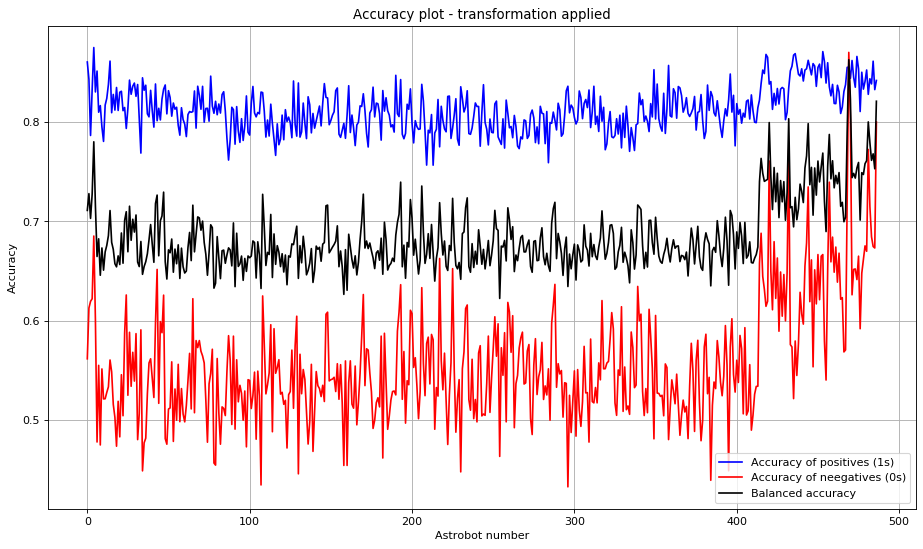

In [37]:
tp_vector = prediction_results[:,5]
neigh_vec = prediction_results[:,0]
tn_vector = prediction_results[:,6]
balacc_vector = prediction_results[:,7]
#print(tp_vector)
plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(tp_vector,'b' ,label = 'Accuracy of positives (1s)')
plt.plot(tn_vector,'r', label = 'Accuracy of neegatives (0s)')
plt.plot(balacc_vector,'k', label = 'Balanced accuracy')
plt.legend()
plt.grid(1)
plt.title('Accuracy plot - transformation applied')
plt.ylabel('Accuracy')
plt.xlabel('Astrobot number')

plt.show()

990.1552361396305 160.80061601642709 132.26817248459957 227.67597535934294
mean over the astrobots for the 1s accuracy:  0.8125079052396265
mean over the astrobots for the 0s accuracy:  0.5552346856231382
mean over the astrobots for the balanced accuracy:  0.6838712954313821
mean over the astrobots for the true positives:  990
mean over the astrobots for the true negatives:  160
mean over the astrobots for the false positives:  132
mean over the astrobots for the false negatives:  227


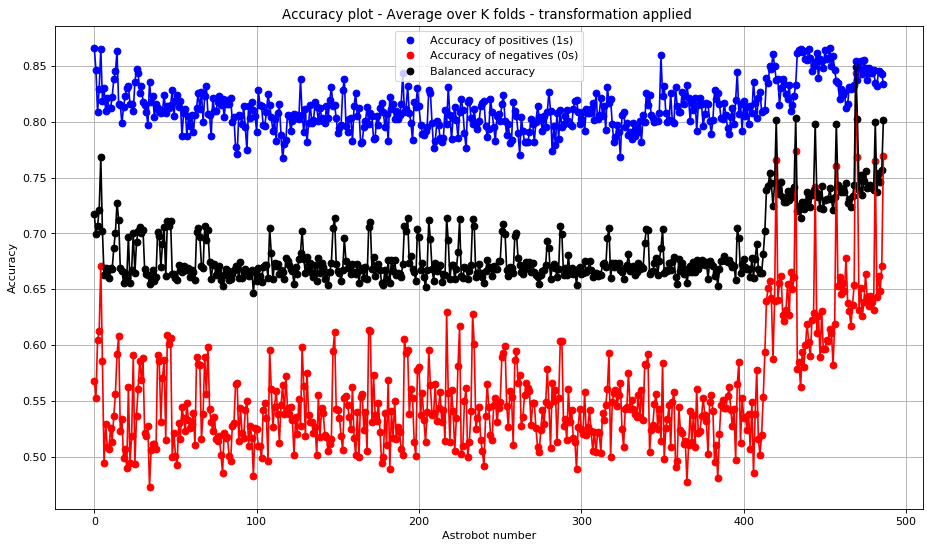

In [38]:
tp_mean=np.mean(tp_vec, axis=0)
tn_mean=np.mean(tn_vec, axis=0)
fp_mean=np.mean(fp_vec, axis=0)
fn_mean=np.mean(fn_vec, axis=0)
tp_vec_mean=np.mean(tp_rate_vec, axis=0)
tn_vec_mean=np.mean(tn_rate_vec, axis=0)
balacc_mean=np.mean(balacc_vec, axis=0)

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(tp_vec_mean,'bo', label = 'Accuracy of positives (1s)')
plt.plot(tn_vec_mean,'ro', label = 'Accuracy of negatives (0s)')
plt.plot(balacc_mean,'ko', label = 'Balanced accuracy')
plt.plot(tp_vec_mean,'b')
plt.plot(tn_vec_mean,'r')
plt.plot(balacc_mean,'k')
plt.legend()
plt.grid(1)
plt.title('Accuracy plot - Average over K folds - transformation applied ')
plt.ylabel('Accuracy')
plt.xlabel('Astrobot number')
#plt.savefig('accuracies_transform.png')
print(np.mean(tp_mean), np.mean(tn_mean), np.mean(fp_mean), np.mean(fn_mean))
print('mean over the astrobots for the 1s accuracy: ', np.mean(tp_vec_mean) )
print('mean over the astrobots for the 0s accuracy: ', np.mean(tn_vec_mean) )
print('mean over the astrobots for the balanced accuracy: ', np.mean(balacc_mean) )
print('mean over the astrobots for the true positives: ', math.trunc(np.mean(tp_mean)))
print('mean over the astrobots for the true negatives: ', math.trunc(np.mean(tn_mean)))
print('mean over the astrobots for the false positives: ', math.trunc(np.mean(fp_mean)))
print('mean over the astrobots for the false negatives: ', math.trunc(np.mean(fn_mean)))

## for i in range(1,number_files):
    print(i)

In [ ]:
a=np.empty((0))
print(a)

In [ ]:
a=np.linspace(1,number_files,number_files)

In [ ]:
print(a)
